# Natural Gas Fuel Cell Flowsheet Example
Original Author: Alexander Noring  
Revision Author: Brandon Paul

# 1. Introduction
This example demonstrates a steady-state simulation of a natural gas fuel cell (NGFC) power plant. Natural gas is reformed into syngas which is directly converted to electricity by the solid oxide fuel cells (SOFC). SOFCs are a type of high temperature fuel cell where oxide ions diffuse through a solid ceramic electrolyte from the cathode (supplied with air) to the anode (supplied with fuel). Since SOFCs do not generate electricity via combustion they are not subject to the Carnot efficiency of conventional generation technologies. SOFCs can theoretically achieve efficiencies greater than 70%. Due to their potential for generating efficient, low pollution power, advanced NGFC systems are being studied as a new addition to the electricity fleet.

The development of this flowsheet is funded by the ARPA-E DIFFERENTIATE project “Machine Learning for Natural Gas to Electric Power System Design” Project number: DE-FOA-0002107-1625. This project is a collaborative effort between the National Energy Technology Laboratory, Pacific Northwest National Laboratory, and the University of Washington to develop NGFC systems with efficiencies greater than 70% and CO2 emissions less than 30 g/kWh. This flowsheet is an initial example of an NGFC system without carbon capture. Future work will add a carbon capture system and explore a broad design space via superstructure optimization.

The flowsheet includes two main sections, the autothermal reformer and the SOFC power island. The flowsheet contains first principles models for most of the unit operations and includes a surrogate model for the SOFC system, an SOFC reduced order model (ROM) has been created by PNNL. The ROM was constructed from the results of thousands of simulations of PNNL's SOFC Multiphysics simulation. It allows us to model the detailed behavior of the SOFC in a computationally efficient way. 

This notebook works by importing and running functions from ```NGFC_flowsheet.py```. Please look at this file for more details on how the sections of the flowsheet are structured. The process of building and solving the flowsheet will be outlined in more detail below.


## 1.1 Autothermal Reformer

In the reformer, natural gas is reacted with steam and air to produce syngas. A recuperator uses the hot syngas to pre-heat the incoming natural gas. Finally, the natural gas bypass stream is also included to enable a certain percentage of internal reformation by the SOFC. The main unit operations are: Autothermal reformer, preheater, and natural gas expander.

## 1.2 SOFC Power Island

In the power island, syngas is supplied to the anode side of the SOFC and air is supplied to cathode. A portion of the anode exhaust is recycled with the remainder being combusted. Both the combustor and cathode exhaust supply heat to a heat recovery steam generator (HRSG) which is used to power a steam turbine. The steam turbine is not explicitly modeled but is assumed to have a thermal efficiency of 38%.

### SOFC ROM

The ROM has been developed using Kriging technique and it takes eight inputs (detailed in section 2.1) and calculates the outlet temperature of the anode and the voltage of the SOFC stack. The DC power output of the SOFC is the voltage times the current (calculated from O2 flowrate across the electrolyte). The energy balance around the SOFC is completed by ensuring that the anode heat duty and the sum of the DC power and cathode heat duty are equal in magnitude. Calling ```build_SOFC_ROM()``` reads in the kriging parameters from a data file and builds constraints for the kriging calculations. It also creates a set of constraints calculating the inputs from the current state of the flowsheet. 

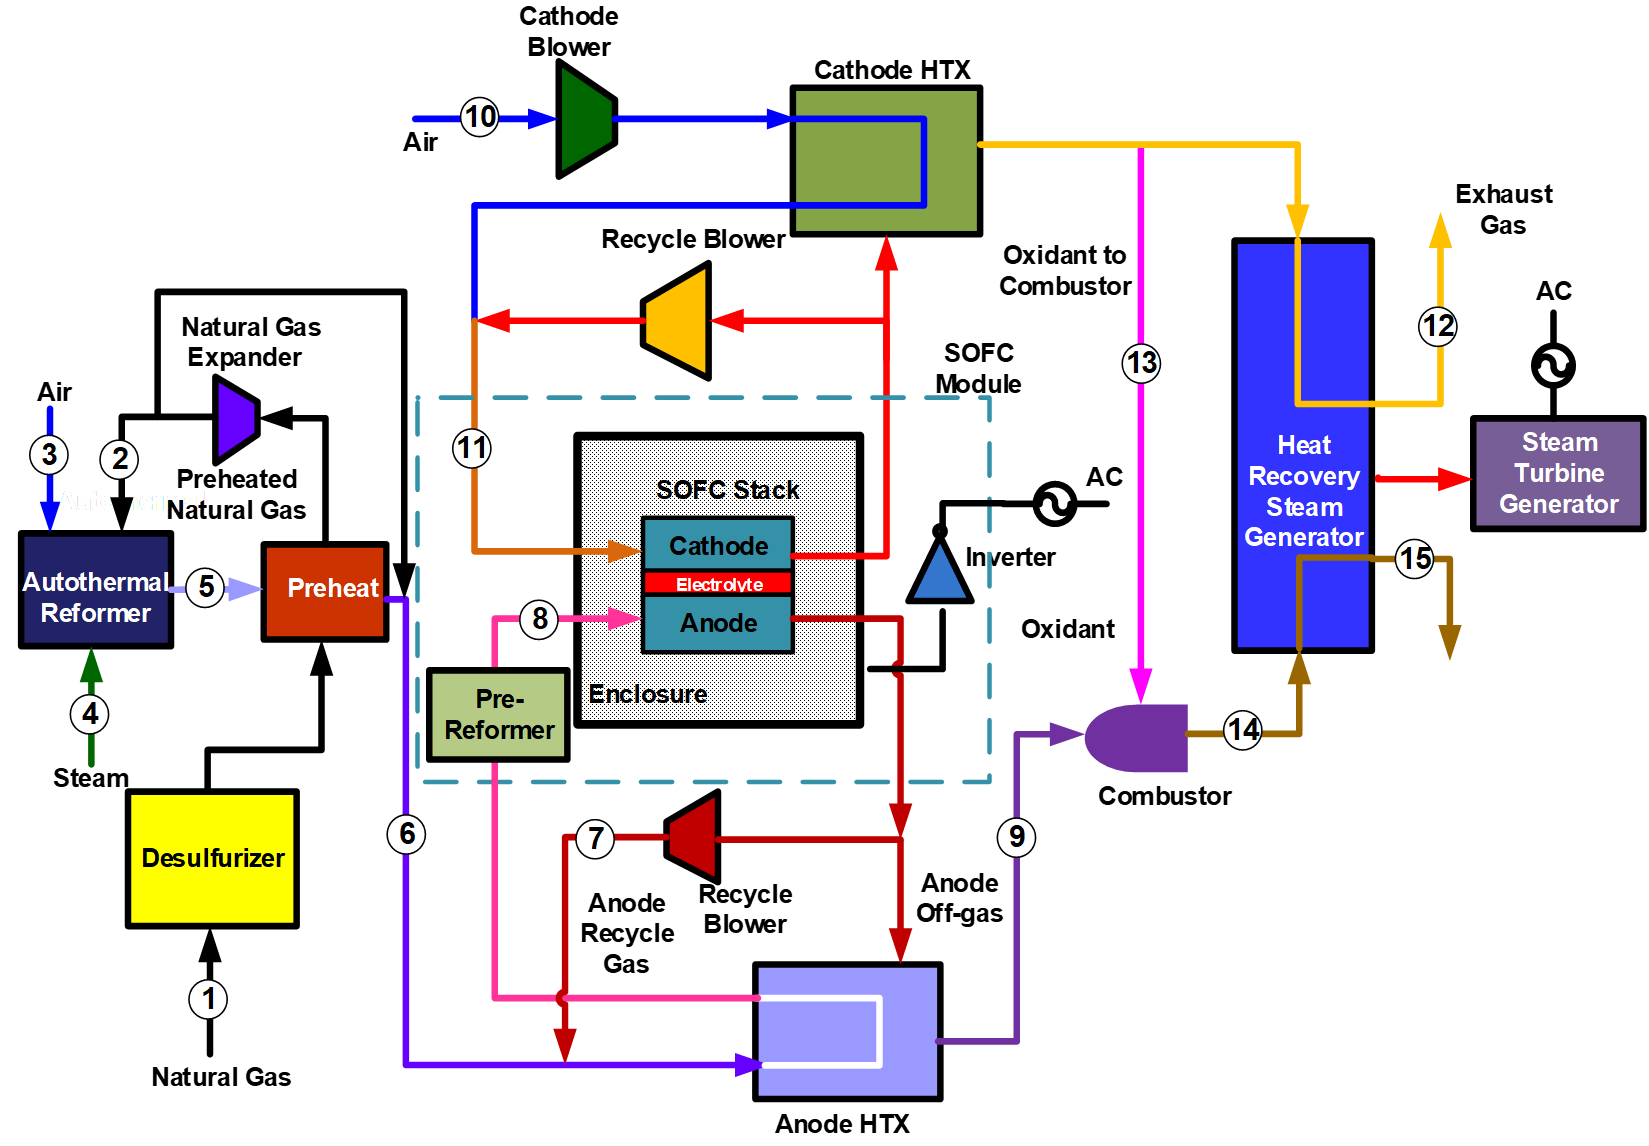

In [1]:
from IPython.display import Image
Image("NGFC_block_flow_diagram.png")

# 2. Problem Statement

For a given current density, fuel temperature, internal reformation percentage, air temperature, oxygen to carbon ratio (OTC), fuel utilization, and air utilization calculate the net power output, efficiency, and carbon emissions of the NGFC system.

The inlet natural gas flowrate and composition must be fixed for the results of the ROM to be accurate.


## 2.1 Main Inputs

- Current density (A/m^2) of the SOFC. The default value is 4000. The range is 2000 - 6000.
- Fuel temperature (C) of the stream entering the SOFC power island. This input is adjusted by changing the outlet temperature of on the hot side of the reformer recuperator. The range is 15 - 600.
- Internal reformation percentage. Due to their high operating temperatures SOFCs are capable of on-cell reformation of methane. The internal reformation percentage is linked to the split fraction of natural gas bypassing the reformer. The range is 0 - 1.
- Air temperature (C) of the stream entering the cathode. This input is controlled by the outlet temperature of the cathode heat exchanger. The range is 550 - 800.
- Cathode recirculation fraction. The cathode recirculation fraction is equal to cathode recycle split fraction. The range is 0 - 0.8.
- OTC, the molar ratio of oxygen to carbon in the stream entering the anode. OTC is controlled by changing the anode recycle split fraction. The range is 1.5 - 3.
- Fuel utilization, the percentage of fuel entering the anode side of the power island that is consumed by the SOFC. In this model the fuel utilization is controlled by changing the amount of oxygen flowing across the electrolyte. The range is 0.40 - 0.95.
- Air utilization, the percentage of air entering the cathode power island that is used by the SOFC. The air utilization is controlled by changing the air inlet flowrate. The range is 0.125 - 0.833.


## 2.2 Main Outputs

- Net power output in MW
- HHV Efficiency of the NGFC
- CO2 emissions

These results can be viewed in the SVG file that is generated after the simulation is run.

# 3. Custom Initialization

Since the flowsheet has multiple recycle streams, the flowsheet initialization consists of splitting the flowsheet in two subsystems (Autothermal reformer and SOFC power island).

Step 1: Build reformer and initialize all the units

```build_reformer()``` creates the unit models in the reformer section and connects them.  ```scale_flowsheet()``` applies appropriate variable and constraint scaling factors to assist with initialization. ```set_reformer_inputs()``` fixes the variables of the inlet streams and unit operations to zero degrees of freedom. ```initialize_reformer()``` uses an initial guess of the reformer outlet to initialize the model. Then the solver is run to get the final solution for this section.

Step 2: Power Island

The sequence of ```build_power_island()```, ```scale_flowsheet()```, ```set_power_island_inputs()```, and ```initialize_power_island()``` creates and initializes the unit models in the power island. At this stage, the inlet to the anode side of the power island is a guess of the syngas conditions. Then the solver is called to finalize the solution to the power island. The solution to the reformer section remains unaffected.

To combine the two sections ```connect_reformer_to_power_island()``` is called. The funtion unfixes the guess for the inlet to power island and connects the outlet of the reformer section to it. Then the solver is called a third time on the fully connected flowsheet.

In execution order, the flowsheet builds each of the two subsections, scales model constraints, sets inputs, initializes independently, and connects the two subsections.

Step 3: Initialize ROM and build SOFC
 
The solver is called to solve the ROM. At this point the ROM is not affecting any unit model variables.

```SOFC_ROM_setup()``` calls the saved SOFC model coefficients and solves for the current inputs, including definitions of fuel and air inlet properties and stack results.

```add_SOFC_energy_balances()``` unfixes the outlet temperature of the anode and enforces a constraint equating the outlet temperature to the value calculated by the ROM. This method also unfixes the heat duty of the cathode and enforces a constraint equating the heat duty to the value that closes the SOFC energy balance calculated using the ROM's stack voltage. The solver is called again.

```add_result_constraints()``` adds expressions for relevant process results.

Finally, the ROM inputs are fixed and the corresponding flowsheet variables are unfixed to allow the user to control to simulation using the ROM inputs.

Step 4 - solve full model: The final initialization step, we solve the complete system.

In [2]:
import os

# Import Pyomo libraries
import pyomo.environ as pyo
from pyomo.environ import units as pyunits

# Import IDAES core
from idaes.core import FlowsheetBlock
from idaes.core.util import model_serializer as ms

# Import NGFC model components
import NGFC_flowsheet as NGFC

In [3]:
# create model and flowsheet
m = pyo.ConcreteModel(name='NGFC no CCS')
m.fs = FlowsheetBlock(dynamic=False)

# create the solver
solver = pyo.SolverFactory("ipopt")
solver.options = {'bound_push':1e-16}

In [4]:
# initialization takes ~ 5 minutes, full solve takes ~ 1 hour
reinit = False  # switch to True to re-initialize and re-solve
resolve = False  # switch to True to re-solve only (for debugging)

if os.path.exists("NGFC_flowsheet_init.json.gz") and reinit is False:
    # already initialized, can build model and load results from json
    NGFC.build_power_island(m)
    NGFC.build_reformer(m)
    NGFC.scale_flowsheet(m)
    NGFC.connect_reformer_to_power_island(m)
    NGFC.SOFC_ROM_setup(m)
    NGFC.add_SOFC_energy_balance(m)
    NGFC.add_result_constraints(m)
    if os.path.exists("NGFC_flowsheet_solution.json.gz") and resolve is False:
        # don't need to solve, can load results from json
        print('Loading solved model')
        ms.from_json(m, fname="NGFC_flowsheet_solution.json.gz")
    else:
        # need to solve the model using loaded initialization point
        # and then serialize solved model results
        print('Loading initialized model')
        ms.from_json(m, fname="NGFC_flowsheet_init.json.gz")
        # solver and options
        solver = pyo.SolverFactory("ipopt")
        solver.options = {
            "max_iter": 50,
            "tol": 1e-5,
            "bound_push": 1e-8,
            "linear_solver": "ma57",
            "ma57_pivtol": 1e-3,
            "OF_ma57_automatic_scaling": "yes",
            "nlp_scaling_method": "user-scaling"
              }
        solve_iteration = 0
        for i in range(1, 10):  # keep looping until condition is met
            solve_iteration += 1
            print('Solve # ', solve_iteration)
            res = solver.solve(m, tee=True)
            if 'Optimal Solution Found' in res.solver.message:
                break
        ms.to_json(m, fname="NGFC_flowsheet_solution.json.gz")
else:
    # need to initialize model, serialize, and try to solve/serialize
    NGFC.build_power_island(m)
    NGFC.build_reformer(m)
    NGFC.scale_flowsheet(m)
    NGFC.set_power_island_inputs(m)
    NGFC.set_reformer_inputs(m)
    NGFC.initialize_power_island(m)
    NGFC.initialize_reformer(m)
    NGFC.connect_reformer_to_power_island(m)
    NGFC.SOFC_ROM_setup(m)
    NGFC.add_SOFC_energy_balance(m)
    NGFC.add_result_constraints(m)
    ms.to_json(m, fname="NGFC_flowsheet_init.json.gz")
    solver = pyo.SolverFactory("ipopt")
    solver.options = {
        "max_iter": 50,
        "tol": 1e-5,
        "bound_push": 1e-8,
        "linear_solver": "ma57",
        "ma57_pivtol": 1e-3,
        "OF_ma57_automatic_scaling": "yes",
        "nlp_scaling_method": "user-scaling"
          }
    solve_iteration = 0
    for i in range(1, 10):  # keep looping until condition is met
        solve_iteration += 1
        print('Solve # ', solve_iteration)
        res = solver.solve(m, tee=True)
        if 'Optimal Solution Found' in res.solver.message:
            break

    ms.to_json(m, fname="NGFC_flowsheet_solution.json.gz")

    deprecated. Arguments can now be passed directly as keyword arguments.
    (called from c:\users\brandonlocal\github\idaes-
    pse\idaes\models\unit_models\gibbs_reactor.py:181)
Scaling flowsheet variables
overwriting mole_frac lower bound, set to 0 to remove warnings
Scaling flowsheet constraints
Calculating scaling factors
2022-09-07 16:03:58 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.prereformer.control_volume.properties_out[0.0]._material_density_term[Vap,H2]
2022-09-07 16:03:58 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.prereformer.control_volume.properties_out[0.0]._material_density_term[Vap,CO]
2022-09-07 16:03:58 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.prereformer.control_volume.properties_out[0.0]._material_density_term[Vap,H2O]
2022-09-07 16:03:58 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.prereformer.control_volume.properties_out[0.0]._material_density_term[Vap,CO2]
2022-09-07 16:

2022-09-07 16:03:58 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.prereformer.control_volume.properties_out[0.0]._material_density_term[Vap,CH4]
2022-09-07 16:03:58 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.prereformer.control_volume.properties_out[0.0]._material_density_term[Vap,C2H6]
2022-09-07 16:03:58 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.prereformer.control_volume.properties_out[0.0]._material_density_term[Vap,C3H8]
2022-09-07 16:03:58 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.prereformer.control_volume.properties_out[0.0]._material_density_term[Vap,C4H10]
2022-09-07 16:03:58 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.prereformer.control_volume.properties_out[0.0]._material_density_term[Vap,N2]
2022-09-07 16:03:58 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.prereformer.control_volume.properties_out[0.0]._material_density_term[Vap,O2]
2022-09-07 16:

2022-09-07 16:03:59 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.reformer.control_volume.properties_out[0.0]._material_density_term[Vap,C2H6]
2022-09-07 16:03:59 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.reformer.control_volume.properties_out[0.0]._material_density_term[Vap,C3H8]
2022-09-07 16:03:59 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.reformer.control_volume.properties_out[0.0]._material_density_term[Vap,C4H10]
2022-09-07 16:03:59 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.reformer.control_volume.properties_out[0.0]._material_density_term[Vap,N2]
2022-09-07 16:03:59 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.reformer.control_volume.properties_out[0.0]._material_density_term[Vap,O2]
2022-09-07 16:03:59 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.reformer.control_volume.properties_out[0.0]._material_density_term[Vap,Ar]
2022-09-07 16:03:59 [WARNING] ida

In [5]:
# After the initial solve, setup the flowsheet to be controlled by changing the ROM inputs
# from solved state, re-solving with new inputs takes ~ 30 minutes

# to ensure overall convergence and discourage local minimia that end in solver loops,
# we take a similar approach as the flowsheet solve and only calculate 25 iterations at a time

# current density
m.fs.SOFC.current_density.fix(4000)

# fuel temperature
m.fs.reformer_recuperator.tube_outlet.temperature.unfix()
m.fs.SOFC.fuel_temperature.fix(348.3)

# internal reformation fraction
m.fs.reformer_bypass.split_fraction[0, 'bypass_outlet'].unfix()
m.fs.SOFC.internal_reforming.fix(0.6)

# air temperature
m.fs.cathode_hx.area.unfix()
m.fs.SOFC.max_cell_temperature.unfix()
m.fs.SOFC.air_temperature.fix(617.3)

# air recirculation fraction
m.fs.cathode_recycle.split_fraction[0, 'recycle'].unfix()
m.fs.SOFC.air_recirculation.fix(0.5)

# oxygen to carbon ratio
m.fs.anode_recycle.split_fraction[0, 'recycle'].unfix()
m.fs.SOFC.OTC.fix(2.1)

# fuel utilization
m.fs.cathode.ion_outlet.flow_mol.unfix()
m.fs.SOFC.fuel_util.fix(0.8)

# air utilization
m.fs.air_blower.inlet.flow_mol.unfix()
m.fs.SOFC.deltaT_cell.unfix()
m.fs.SOFC.air_util.fix(0.4488)

from idaes.core.util.model_statistics import degrees_of_freedom
print('DOF = ', degrees_of_freedom(m))
print()
solver = pyo.SolverFactory("ipopt")
solver.options = {
    "max_iter": 50,
    "tol": 1e-4,
    "bound_push": 1e-8,
    "linear_solver": "ma57",
    "ma57_pivtol": 1e-3,
    "OF_ma57_automatic_scaling": "yes",
    "nlp_scaling_method": "user-scaling"
      }
solve_iteration = 0
for i in range(1, 10):  # keep looping until condition is met
    solve_iteration += 1
    print('Solve # ', solve_iteration)
    status = solver.solve(m, tee=True)
    if 'Optimal Solution Found' in status.solver.message:
        break


DOF =  0

Solve #  1
Ipopt 3.13.2: max_iter=50
tol=0.0001
bound_push=1e-08
linear_solver=ma57
ma57_pivtol=0.001
nlp_scaling_method=user-scaling
option_file_name=C:\Users\BRANDO~1\AppData\Local\Temp\tmpklv_exqq_ipopt.opt

Using option file "C:\Users\BRANDO~1\AppData\Local\Temp\tmpklv_exqq_ipopt.opt".


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for larg

In [6]:
# For testing purposes
from pyomo.environ import TerminationCondition, value
assert status.solver.termination_condition == TerminationCondition.optimal

assert degrees_of_freedom(m) == 0

import pytest
assert (pytest.approx(660.608, rel=1e-5) == value(m.fs.net_power))
assert (pytest.approx(0.625588, rel=1e-5) == value(m.fs.HHV_efficiency))
assert (pytest.approx(291.249, rel=1e-5) == value(m.fs.CO2_emissions))

print("Problem solved successfully")

Problem solved successfully


# 4 SVG Results

The results of the simulation can be viewed in the SVG file below.

It can be seen from the figure that the bulk of the power generated by the NGFC plant is from the SOFCs (542.6 MW). The steam turbine and natural gas expander both contribute smaller amounts at 107.3 and 21.1 MW, respectively. The auxiliary load from the recycle blowers and air compressors is only 10.4 MW. The net power of the system is 660.6 MW.

The higher heating value of the natural gas feed is 908,839 J/mol. Multiplying by the inlet flowrate of 1,161 mol/s gives a total thermal input of 1056 MW. Based on the thermal input and the net generation the efficiency is 62.56%. The carbon emissions are 291.2 g/kWh.

The results also show the closure of the energy balance around the SOFC. The heat duty of the anode is -673.92 MW and the duty of the cathode is 114.57 MW. When added together they produce the DC stack power with an absolute value of 559.3 MW.

In [7]:
# prepare the SVG file with results
NGFC.make_stream_dict(m)
from idaes.core.util.tables import create_stream_table_dataframe
df = create_stream_table_dataframe(streams=m._streams, orient="index")
NGFC.pfd_result("NGFC_results.svg", m, df)

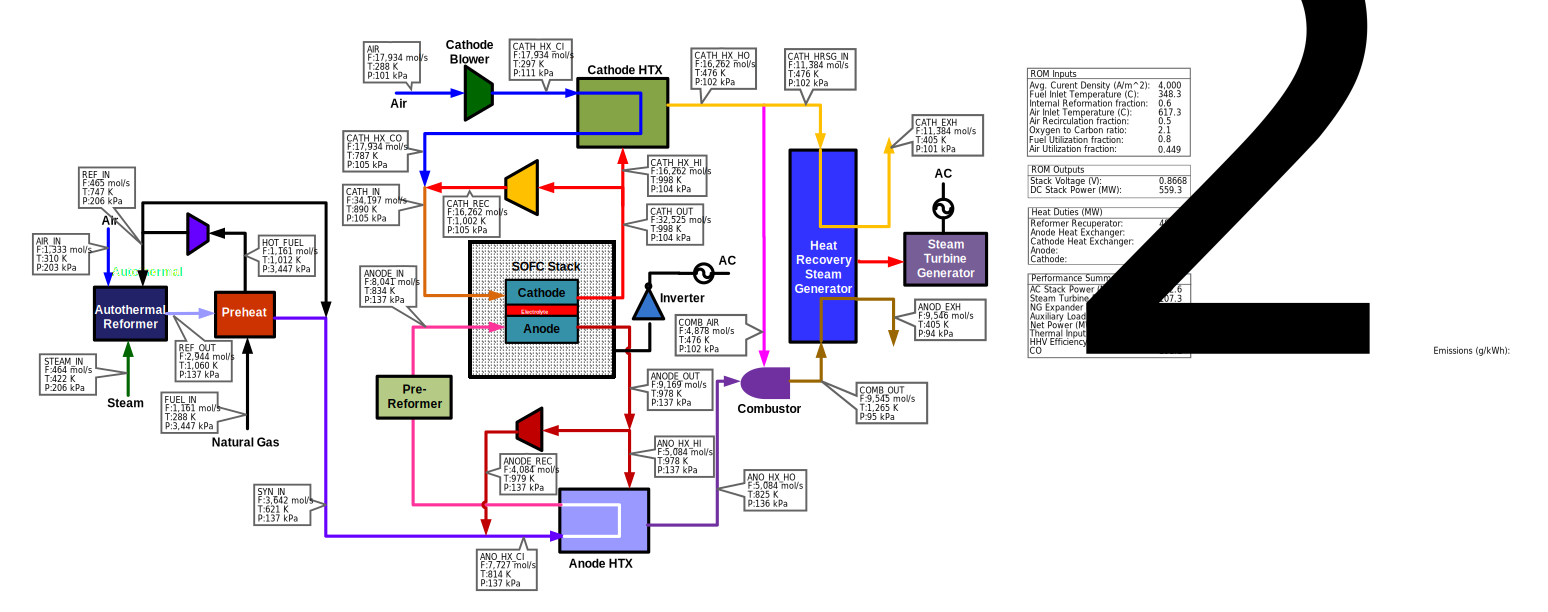

In [8]:
# display the SVG file
from IPython.display import Image, SVG, display
display(SVG(filename="NGFC_results.svg"))

# if SVG file doesn't display in-line you can open the file in a web browser to view results